In [1]:
import torch
from torch import exp
import matplotlib.pyplot as plt
from fastai.data.external import  *
from fastai.vision.all import *

# Что это за цифра?


- badges: true
- comments: true
- categories: [fastpages, jupyter]

В этой статье будет показано, как написать простейшую модель для распознавания чисел с нуля. Но для начала разберемся, как вообще происходит обучение модели.

## Схема модели

Представим, как должна выглядеть наша модель. Мы подаем ей на вход изображение размером X на Y пикселей, она выполняет некоторые вычисления и на выходе выдает нам один из следующих результатов: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}. Другими словами, на вход подается X\*Y значений - значения, который принимает каждый из пикселей, на выходе получаем 10 значений - вероятность принадлежности к каждому из классов, после этого выбираем класс, вероятность принадлежности к которому наибольшая - это и есть наш ответ.

Каким образом можно определить принадлежность картинки к одному из классов? Так как каждая цифра пишется имеет свою форму, свой силует, то можно понять, что какие-то зоны картинки будут больше задействованы у одной цифры и меньше - у другой. То есть можно сказать, что для каждой цифры какие-то пиксели будут задействованы с большей вероятностью, какие-то - с меньшей. Если мы каждому пикселю для каждой цифры сопоставим определенный вес, то по сумме произведений весов на значения соответсвующих пикселей можно будет сделать предположение, какая цифра перед нами. Однако функция w\*x не очень "эластична", например, если x (значение пикселя) равен 0, то как ни меняй w (вес), произведение останется 0. Со школы мы знаем, что функция прямой имеет вид y = w\*x + b, её мы и будем использовать. Переменную b обозначим как сдвиг. Оставим пока такое несколько упрощенное представление о работе модели и пойдем дальше.

Давайте попробуем схематично изобразить такую модель. Сразу это сделать может быть трудновато, поэтому для начала рассмотрим более простой случай: пусть у нас есть только два варианта. Например, будем различать нули и единицы. Соответственно, нам на выходе понадобится только одно значение: условно, можно считать, если оно принимает значение больше нуля, то на изображении ноль, иначе - единица. Тогда схема будет примерно следующей:

![](my_icons/is0.png)

Еще раз посмотрим на схему и попробуем понять. На входе n значений - значения пикселей, где n=X\*Y (X, Y - высота и ширина рисунка в пикселях). Далее мы должны с этими параметрами что-то сделать, получить какие-то другие значения, что достигается засчет весов w и сдвига b. Веса и сдвиг вместе называются *параметрами*. Именно эти параметры мы можем изменять во время обучения, чтобы достигнуть наибольшей точности. Преобразовав входные значения с помощью линейного преобразования (умножаем вход на веса, складываем и добавляем сдвиг), мы получаем первый линейный слой. В нашем простом случае ограничимся одним единственным скрытым слоем. Чтобы получить единственное значение, говорящее нам - ноль это или единица, применим к результату некоторую функцию. Эту функцию называют *функцией активации*. О ней поговорим позже, но пока можно сказать, что применяем мы ее, поскольку мы же хотим каким-то образом ограничить значения, выдаваемые нашей моделью, чтобы на их основе делать какие-либо выводы. То, что нам выдаст эта функция, и будет нашим выходным значением.

С простым случаем вроде разобрались. Что же происходит в случае, когда нам нужно на выходе не одно, на несколько значений? Если мы хотим определять все цифры, а не только нули и единицы, то нам, как ни крути, понадобится 10 выходных значений. Схема для такого случая будет расширением схемы, которую мы только что разобрали. Давайте посмотрим: 

![](my_icons/what_numb.png)

Все абсолютно аналогично, просто на первом слое у нас не n значений, а n\*10. Соответственно, изменяется и размерность массивов параметров: веса становятся двумерным массивом \[n,10\], а сдвиг задается одномерным массивом длиной 10. После линейного преобразования мы получаем некоторые 10 значений, которые после прохождения через функцию активации дадут нам 10 других значений - вероятности принадлежности к каждой из 10 цифр. После этого можно выбрать один класс - вероятность принадлежности к которому больше всего. Эта последовательность действий будет происходить для всех изображений, которые мы подаем на вход нашей модели.

## Линейный слой и функция активации

Как это все выглядит в коде? Входные данные - массив \[k,X\*Y\], где k - количество изображений, на которых мы хотим определить цифру; массив весов имеет размерность \[X\*Y,10\]; массив сдвигов - \[1,10\]. Конечно, вы могли заметить, что умножение входных параметров на вес и последующее суммирование - это матричное умножение, в результате которого получаем массив размером \[k,10\]. После прибавления к этому массиву массива сдвигов размерность не изменяется.

Давайте посмотрим на код, отвечающий за линейное преобразование:

In [2]:
#задаем линейный слой
def linear1(xb): return xb@weights + bias

Символ "@" здесь отвечает за умножение матриц.

Поговорим теперь о функции активации. Значения, которые выдает линейный слой, могут принимать совершенно разные значения от -∞ до ∞ . Хотелось бы ограничить их, скажем, значениями от 0 до 1. Тогда результаты применения функции можно будет трактовать как вероятность принадлежности к классу. Именно это будет делать функция активации: каждому значению на всей числовой прямой будем ставить в соответствие значение от 0 до 1.

Такая функция у нас есть: она называется сигмоида, задается выражением 1/(1+exp(-x)) и выглядит следующим образом:

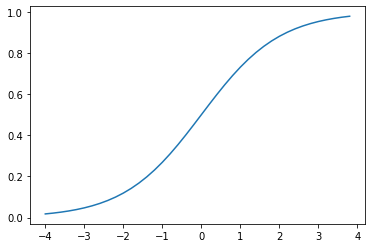

In [3]:
def sigmoid(x): return 1/(1+exp(-x))

x = torch.arange(-4,4,0.2)
plt.plot(x,sigmoid(x))
plt.show()

Она прекрасно работает, в случае одного выходного значения, фактически выдавая вероятность принадлежности к одному из двух классов. Например, в том простом случае, когда мы отличаем изображения нулей от изображений единиц: чем результат сигмоиды ближе к 1, тем вероятнее, что на картинке ноль. 

Но когда мы хотим распознать 10 цифр, ситуация немного меняется. Памятуя о том, что результаты функции активации мы хотим трактовать как вероятности принадлежности к каждому из классов, приходится внести некоторые изменения к требованиям к данной функции. В нашем случае функции активации подается 10 значений, поэтому кроме требования принадлежности результатов отрезку \[0,1\], добавляется требование равенства единице суммы всех этих значений. В самом деле, сумма вероятностей всех исходов событий всегда равняется 1.

Тут нам на помощь приходит функция softmax. Она задается следующим образом:

In [4]:
def softmax(x): return exp(x)/exp(x).sum(dim = 1, keepdim = True)

Softmax принимает на вход массив значений и преобразует его в массив, в котором каждое число лежит в отрезке от 0 до 1 и сумма всех значений равна 1. Это мультикатегориальный аналог сигмоиды.

Посмотрим, как это работает:

In [5]:
#Пусть у нас есть две картинки и три класса. После линейного преобразования мы получили следующие значения:
out = torch.tensor([[0.02,-2.49,1.25],
                  [0.01,-3.4,1.1]])
#Применим экспоненциальную функцию
exponential = exp(out)
#Применим softmax
sftmx = softmax(out)
print('Exp(out):',exponential, 'sum:', exponential.sum(dim=1))
print('Softmax(out):', sftmx, 'sum:', sftmx.sum(dim=1))

Exp(out): tensor([[1.0202, 0.0829, 3.4903],
        [1.0101, 0.0334, 3.0042]]) sum: tensor([4.5935, 4.0476])
Softmax(out): tensor([[0.2221, 0.0180, 0.7599],
        [0.2495, 0.0082, 0.7422]]) sum: tensor([1.0000, 1.0000])


На таком небольшом примере удобно попробовать подсчитать все самому и наглядно увидеть, как работает softmax.

Экспоненциальная функция внутри softmax-а гарантирует, что все значения будут положительны, а деление на сумму гарантирует, что все значения будут суммироваться к 1. Кроме этого, так как экспонента растет быстро, даже небольшое превосходство одного значения над другим будет сильно заметно после применения данной функции активации.

## Стохастический градиентный спуск и функция потерь

Теперь мы имеем представление о том, как будет выглядеть наша модель. Разберемся, как мы будем ее обучать. 

Цель обучения модели - подобрать параметры так, чтобы модель делала правильные предсказания на входных данных с удовлетворяющей нас точностью.

Чтобы подобрать параметры таким образом, мы будем скармливать модели картинки с уже известными ответами - помеченный датасет. Ожидается, что модель возьмет картинку, прогонит ее по алгоритму, который мы разобрали выше, сравнит свое предсказание с правильным ответом и откорректирует параметры, если ответ не сойдется. В данной последовательности действий наибольшую сложность предстваляет именно корректировка параметров. Каким образом их изменять, насколько и в какую сторону? Давайте попробуем разобраться.

Очевидно, корректировать параметры надо так, чтобы качество предсказаний улучшалось. Введем некую функцию, которая бы показывала нам, насколько хорошо предсказывает наша модель, в конкретных числовых значениях, а не в абстрактных категориях "хорошо" и "плохо". Такую функцию будем называть *функцией потерь*. Условимся, что чем меньшее значение она принимает, тем лучше предсказывает модель. 

Тогда целью корректировки параметров становится минимизация функции потерь. Будем решать задачу минимизации с помощью градиентного спуска. Напомню, что градиент n-мерной функции - это вектор, компоненты которого являются частными производными функции по всем ее аргументам. Градиент показывает направление и скорость наискорейшего роста функции (другими словами, помогает найти самый крутой подъем).

Вспомним, как работает градиент на простеньком примере:

In [6]:
#Пусть у нас задана следующая функция, принимающая вектор в качестве параметра:
def f(x): return (x**2).sum()

#Возьмем в качетсве аргумента вектор (2,-3,7) и с помощью функции requires_grad_() укажем, 
#что в будущем мы будем брать производную по этому аргументу
inp = torch.tensor([2.,-3.,7.]).requires_grad_()

#Обратите внимание, что при выводе указывается не только значение функции, но и функция градиента
y = f(inp)
print(y)

tensor(62., grad_fn=<SumBackward0>)


In [7]:
#Теперь посчитаем само значение градиента для данного аргумента.
y.backward()

#Чтобы получить это значение, обращаемся к параметру grad аргумента inp
print(inp.grad)

tensor([ 4., -6., 14.])


Если вспомнить старшие классы школы и посчитать частные производные функции, то можно увидеть, что так и получится.

Градиент говорит нам о крутизне функции, поэтому можно предположить, что если абсолютное значение его мало, то мы близки к оптимальному значению (в точках локальных минимумов и максимумов градиент равен 0). Отрицательные значения говорят о том, что идет спуск, положительные - что идет подъем.

Отлично, градиент вспомнили, двигаемся дальше.

Чтобы достичь минимума функции будем изменять наши параметры в зависимости от их градиента:

`w -= (w.grad * lr)`

Так как градиент показывает направление наикрутейшего подъема, а нам нужен минимум, а не максимум функции, мы будем двигать наши параметры в направлении антиградиента, отсюда в формуле выше и возникает знак минус.

lr в предыдущей формуле - *learning rate*, *темп обучения* - параметр, который влияет на величину шага изменения параметров. Обычно темп обучения принимает небольшие значения, от 0.1 до 0.00001, в зависимости от значений конкретной задачи. Если взять этот параметр слишком большим, то есть риск проскочить мимо минимума на каком-то шаге, значения функции потерь начнут увеличиваться или будут сходиться очень-очень долго, практически оставаясь на одном и том же месте, а если взять темп обучения, наоборот, слишком маленьким, то оптимизация параметров, а значит и весь процесс обучения модели, займет очень много времени.

![](my_icons/learning_rate.png)
<span>*Изображения взяты из курса fastai 2021*</span>

Теперь должно быть приблизительно понятно, как минимизировать функцию потерь. Но остается вопрос: как выбрать эту самую функцию? Разберемся.

Во-первых, зачем вообще нужна функция потерь? Как я уже говорила, она численно показывает, наколько хороша наша модель при данных параметрах. Почему тогда мы не можем взять в качестве неё отношение правильных ответов к общему числу предсказаний, которое используем, когда хотим другим рассказать, насколько точна наша модель? Представим такую ситуацию: мы хотим узнать по картинке, кто на рисунке - собака или кошка. Мы считаем, что если ответ модели больше 0.5, то это кошка, иначе собака. На какой-то момент наши параметры имеют значения \[-3.5, 1.495, 703.04\] и модель с такими параметрами дает нам следующие предсказания для четырех входных данных - \[0.7, 0.34, 0.2, 0.999\], то есть кошка-собака-собака-кошка. А правильные ответы для этих четырех изображений - собака-собака-собака-собака. То есть два правильных предсказания из четырех, точность модели 2/4 = 0.5. Мы хотим ненамного изменить параметры и посмотреть, как изменятся предсказания модели. Меняем параметры на несколько сотых: \[-3.55, 1.5, 703.02\]. В итоге получаем следующие предсказания для тех же входных данных: \[0.51, 0.29, 0.09, 0.63\]. Видно, что полученные ответы стали гораздо лучше, уменьшившись в сторону ответа "собака", а значит мы меняем параметры в верном направлении. Однако конечные ответы модель выдает все те же: кошка-собака-собака-кошка, а значит, точность осталась прежней: 0.5. Поэтому, если в качестве функции потерь мы возьмем данное отношение, то мы просто не заметим улучшение в работе модели и не будем знать, куда двигать параметры. Другими словами, данное значение точности модели меняется только при изменении самых конечных ответов - предсказаний классов, такая функция является ступенчатой функцией и производная по ней практически везде (кроме точек разрыва) равна 0, а значит с ее помощью нельзя изменить параметры.

Поэтому-то нам и нужно брать в качестве функции потерь такие функции, которые будут не столько информативны для человека, сколько удобны для дальнейших вычислений, функции, по которым можно брать производные, чтобы можно было заметить влияние, которое оказывает малейшее изменение параметра.

Функция потерь берет в качестве параметра не сами параметры, а предсказания и сравнивает их с правильными ответами. 

Пожалуй, первое, что приходит на ум - посчитать среднюю удаленность предсказаний от правильных ответов. Это было бы удобно, если бы у нас было всего два класса: 0 и 1. Тогда мы могли бы сделать следующее (считаем, что к предсказаниям уже применена функция активации и они имеют значение от 0 до 1):

In [8]:
def loss(preds, targets):
    ans = []
    for t, p in zip(targets, preds):
        if t == 1:
            ans.append(1-p)
        else:
            ans.append(p)
    return torch.tensor(ans).mean()

#Попробуем на конкретном примере
loss(torch.tensor([0.9, 0.4, 0.2]),torch.tensor([1,0,1]))

tensor(0.4333)

или то же самое, но в одну строчку и быстрее:

In [9]:
def loss(preds, targets):
    return torch.where(targets==1, 1-preds, preds).mean()

#Проверим на том же примере на всякий случай
loss(torch.tensor([0.9, 0.4, 0.2]),torch.tensor([1,0,1]))

tensor(0.4333)

Как действует данная функция? Рассмотрим на нашем примере с предсказаниями \[0.9, 0.4, 0.2\] и ответами \[1, 0, 1\]. Что такое эти предсказания? Если задуматься, то это вероятности принадлежности входных значений к классу 0. Действительно, раз мы считаем, что значения >= 0.5 - это класс 0, а значения < 0.5 - класс 1, то чем больше значение, тем скорее это 0 класс, а чем меньше значение, тем вероятнее, что это 1 и тем менее вероятно это 0. То есть если правильный ответ 0, то мы оставляем такое значение, какое есть, а если 1, то берем значение (1-предсказание), затем берем среднее из этих значений. Получается, мы находим среднее из вероятностей принадлежности каждого входного объекта к истинному классу.

Как бы нам сделать так, чтобы всё считалось по тому же приципу и в случае, когда классов больше, чем два? Если мы возьмем конкретный пример, то сразу станет понятно, что у нас для этого все есть:

In [10]:
# Пусть у нас 6 картинок и 3 класса, модель выдает следующие предсказания
preds = torch.randn((6,3))*2
preds

tensor([[ 1.8121, -1.3010,  4.1523],
        [-1.9579, -0.1233, -1.5999],
        [ 4.0000, -1.6705,  1.9482],
        [ 0.5459,  1.9679,  5.7474],
        [ 0.3846, -1.4243, -1.0640],
        [ 0.8246,  2.4619, -4.3599]])

In [11]:
# Применим функцию активации softmax
smx_preds = softmax(preds)
smx_preds

tensor([[8.7503e-02, 3.8907e-03, 9.0861e-01],
        [1.1503e-01, 7.2042e-01, 1.6455e-01],
        [8.8343e-01, 3.0445e-03, 1.1353e-01],
        [5.3569e-03, 2.2205e-02, 9.7244e-01],
        [7.1493e-01, 1.1713e-01, 1.6794e-01],
        [1.6269e-01, 8.3640e-01, 9.1145e-04]])

In [12]:
#Пусть правильные ответы задаются следующим образом
targ = torch.tensor([0,1,0,2,2,0])

Теперь у нас есть вероятности, с которыми каждая картинка принадлежит к каждому из классов по мнению модели. Но ведь это то, что мы считали в бинарном случае! Значит, нам остается только взять среднее из вероятностей, с которыми объекты принадлежат к верным классам. Это легко сделать, достаточно взять для каждого обхекта предсказание с индексом - верным ответом:

In [13]:
ndxs = range(6)
nll_loss = smx_preds[ndxs,targ].mean()
nll_loss

tensor(0.4991)

Такая функция потерь называется NLL - *Negative Log Likelihood*. Но несмотря на название, как вы заметили, логарифмы в ней не используются. Дело в том, что логарифм обычно используют перед тем, как применить эту функцию. Зачем - рассказываю ниже.

Недостаток функции потерь NLL в том, что она получает и выдает значения от 0 до 1, так как работает с вероятностями. И получается, например, что разница между значениями 0.99 и 0.999 не так заметна, хотя выходит, что во втором случае модель работает в 10 раз лучше. Поэтому было бы удобно, если бы она могла работать со вмеми положительными числами. Тут-то нам и поможет логарифм (мы будем использовать натуральный логарифм). Напомню, что график натурального логарифма выглядит следующим образом:

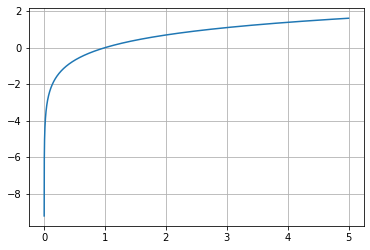

In [14]:
x = torch.arange(0,5,0.0001)
fig, ax = plt.subplots()
ax.grid(True)
ax.plot(x, torch.log(x))

На отрезке от 0 до 1 логарифм принимает значения от -∞ до 0. Если умножить логарифм на -1, то мы будем иметь дело со всеми положительными значениями, что нам и нужно.

Итак, улучшим нашу функцию потерь:

In [15]:
cross_entropy = -torch.log(smx_preds[ndxs,targ]).mean()
print(cross_entropy)

tensor(1.0860)


Такая функция потерь называется *CrossEntropyLoss*. Интересное замечание: градиент от CrossEntropyLoss(preds, targ) равен softmax(preds)-targ. То есть градиент прямо пропорционален удаленности предсказания от правильного ответа.

CrossEntropyLoss используется в задачах классификации, когда нам по сути нужно выбрать ответ из нескольких заранее установленных значений - классов. Если же перед нами стоит задача регрессии, то есть нам надо предсказать вещественное число (перед нами нет вариантов, ответ может быть любым на непрерывной числовой оси), тогда используется *среднеквадратичная функция потерь* - *MSE*, *Mean Squared Error*. Она задается следующей формулой:
```
mse_loss = ((preds-targ)**2).mean().squared()
```

Последнее, что хотелось бы обговорить. Сколько входных данных лучше давать модели, чтобы проверять качество предсказаний и корректировать параметры? Если мы отдадим ей сразу весь датасет, то она будет очень долго его обрабатывать. Если же мы будем передавать по одной картинке, то изменения будут очень нестабильны и не очень информативны, ведь параметры будут меняться после каждого входного значения. Кроме того, в этом случае подсчеты на GPU не дадут никакого выигрыша в произодительности, ведь графический процессор должен быть полностью загружен, чтобы распараллеливание задач имело смысл. Идеальный вариант, как всегда, по середине. Обычно весь датасет делят на несколько небольших наборов входных данных (mini-batches), по очереди загружают их в модель и берут среднее значение функции потерь по каждому набору. Когда все мини-наборы прошли через цикл модель-функция потерь-корректировка параметров, говорят, что прошла одна *эпоха*. Выбор размера этих небольших наборов (количества данных в каждом наборе) тоже ответственная задача: чем больше их размер, тем точнее и стабильнее оценка потерь, но тем дольше обучение. Размер должен быть таким, чтобы обеспечивать достаточную нагрузку на GPU и чтобы обучение проходило быстро и точно.

Базовые этапы обучения модели разобраны, осталось объединить их в единое целое. Повторим еще раз, как должно происходить обучение модели.
1. Задаем параметры - мы можем задать их случайным образом, нам в любом случае их менять, поэтому нет смысла тратить много времени, чтобы попробовать их изначально подобрать.
2. Прогоняем мини-набор входных данных через модель, получаем предсказания.
3. Применяем функцию активации к предсказаниям и вычисляем значение функции потерь - смотрим, насколько хороша наша модель; если устраивает - переходим к пункту 5.
4. Изменяем параметры на основе градиента функции потерь, переходим к пункту 2.
5. Оканчиваем обучение, сохраняем параметры.

## Собираем в единое целое

Для обучения модели будем использовать классический датасет с цифрами MNIST. Загрузим его:

In [16]:
#загружаем датасет
path = untar_data(URLs.MNIST)

#для дальнейшего удобства делаем путь к этому датасету базовым
Path.BASE_PATH = path

#посмотрим, что внутри скачанной папки
path.ls()

(#2) [Path('testing'),Path('training')]

Датасет состоит из двух частей: training - для обучения и testing - для оценки точности модели на данных, которые модель до этого не видела.

In [17]:
#сейчас нам нужна папка training, посмотрим, что в ней
(path/'training').ls()

(#10) [Path('training/0'),Path('training/1'),Path('training/2'),Path('training/3'),Path('training/4'),Path('training/5'),Path('training/6'),Path('training/7'),Path('training/8'),Path('training/9')]

Внутри 10 папок с изображениями для каждой цифры. Сохраним в отдельные переменные для каждой цифры набор путей до ее изображений.

In [18]:
zeroes = (path/'training'/'0').ls()
ones = (path/'training'/'1').ls()
twos = (path/'training'/'2').ls()
threes = (path/'training'/'3').ls()
fours = (path/'training'/'4').ls()
fives = (path/'training'/'5').ls()
sixes = (path/'training'/'6').ls()
sevens = (path/'training'/'7').ls()
eigths = (path/'training'/'8').ls()
nines = (path/'training'/'9').ls()

#посмотрим, что лежит теперь, например, в переменной zeroes
zeroes

(#5923) [Path('training/0/1.png'),Path('training/0/1000.png'),Path('training/0/10005.png'),Path('training/0/10010.png'),Path('training/0/10022.png'),Path('training/0/10025.png'),Path('training/0/10026.png'),Path('training/0/10045.png'),Path('training/0/10069.png'),Path('training/0/10071.png')...]

Как мы и думали, в каждой папке полно изображений цифр. Например, для нуля там 5923 картинки. Давайте возьмем одну для примера и посмотрим, как она выглядит.

In [19]:
im0 = Image.open(zeroes[0])
im0

Так как все картинки черно-белые, что они хранятся как матрица чисел, где каждый элемент матрицы - значение яркости соответствующего пикселя. Каждая картинка в датасете имеет размер 28 на 28 пикселей. Черный цвет задается нулем, белый - 255. Чтобы в этом убедиться, давайте посмотрим на кусочек картинки в числовом варианте:

In [20]:
#представим картинку как массив и возьмем кусочек из левого 
#верхнего угла (немного сдвинутый, иначе захватится только черный квадрат)
array(im0)[1:20,5:15]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  48],
       [  0,   0,   0,   0,   0,   0,   0,   0,  54, 227],
       [  0,   0,   0,   0,   0,   0,  10,  60, 224, 252],
       [  0,   0,   0,   0,   0,   0, 163, 252, 252, 252],
       [  0,   0,   0,   0,   0,  51, 238, 253, 253, 190],
       [  0,   0,   0,   0,  48, 238, 252, 252, 179,  12],
       [  0,   0,   0,  38, 165, 253, 233, 208,  84,   0],
       [  0,   0,   7, 178, 252, 240,  71,  19,  28,   0],
       [  0,   0,  57, 252, 252,  63,   0,   0,   0,   0],
       [  0,   0, 198, 253, 190,   0,   0,   0,   0,   0],
       [  0,  76, 246, 252, 112,   0,   0,   0,   0,   0],
       [  0,  85, 252, 230,  25,   0,   0,   0,   0,   0],
       [  0,  85, 252, 223,   0,   0,   0,   0,   0,   0

К слову, довольно красиво это можно отобразить с библиотекой Pandas.

In [21]:
import pandas as pd
df = pd.DataFrame(tensor(im0))
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('gray')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,159,253,159,50,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,238,252,252,252,237,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,54,227,253,252,239,233,252,57,6,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,10,60,224,252,253,252,202,84,252,253,122,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,163,252,252,252,253,252,252,96,189,253,167,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,51,238,253,253,190,114,253,228,47,79,255,168,0,0,0,0,0,0


Создадим для каждой цифры один большой массив: соберем все картинки в качестве числовых массивов в один массив.

In [22]:
zeroes_tensors = [tensor(Image.open(o)) for o in zeroes]
ones_tensors = [tensor(Image.open(o)) for o in ones]
twos_tensors = [tensor(Image.open(o)) for o in twos]
threes_tensors = [tensor(Image.open(o)) for o in threes]
fours_tensors = [tensor(Image.open(o)) for o in fours]
fives_tensors = [tensor(Image.open(o)) for o in fives]
sixes_tensors = [tensor(Image.open(o)) for o in sixes]
sevens_tensors = [tensor(Image.open(o)) for o in sevens]
eigths_tensors = [tensor(Image.open(o)) for o in eigths]
nines_tensors = [tensor(Image.open(o)) for o in nines]

Сейчас у нас для каждой цифры массив тензоров, но для более удобного доступа к значениям будет лучше иметь один тензор 3 ранга. В этом нам поможет метод stack(). Сейчас у нас в тензоре только целые числа от 0 до 255, но с целыми числами не очень удобно работать, поскольку в итоге нам все равно придется иметь дело в вещественными числами, например, когда будем брать среднее значение функции потерь. Поэтому приведем все числа к вещественным значениям методом float(), ну и поскольку мы избавились от целых чисел, то будет гораздо лучше, если у нас будут храниться числа от 0 до 1. Для этого поделим все значения на 255.

In [23]:
stacked_zeroes = torch.stack(zeroes_tensors).float()/255
stacked_ones = torch.stack(ones_tensors).float()/255
stacked_twos = torch.stack(twos_tensors).float()/255
stacked_threes = torch.stack(threes_tensors).float()/255
stacked_fours = torch.stack(fours_tensors).float()/255
stacked_fives = torch.stack(fives_tensors).float()/255
stacked_sixes = torch.stack(sixes_tensors).float()/255
stacked_sevens = torch.stack(sevens_tensors).float()/255
stacked_eigths = torch.stack(eigths_tensors).float()/255
stacked_nines = torch.stack(nines_tensors).float()/255

#на всякий случай проверим размерность получившегося тензора и убедимся, что все хорошо
stacked_zeroes.shape

torch.Size([5923, 28, 28])

Мы будем загружать в модель не отдельные цифры, а все вместе, поэтому объединим все цифры в один тензор, для этого используем метод cat(). Кроме того нам вообще-то не нужно представлять каждую картинку как матрицу 28х28, а гораздо удобнее будет "выстроить все пиксели в один ряд", то есть представить картинку как массив длиной 784 (=28^2). Тогда наш тензор 3 ранга превращается в тензор 2 ранга, для этого есть метод view(), который мы вызовем с параметрами view(-1,28\*28), что означает, что существующий тензор должен перегруппироваться так, чтобы вторая размерность была 784, а первая - подбирается исходя из известных размерностей.

In [24]:
train_x = torch.cat([stacked_zeroes, stacked_ones, stacked_twos, stacked_threes, stacked_fours, stacked_fives, stacked_sixes, stacked_sevens, stacked_eigths, stacked_nines]).view(-1,28*28)

#проверим размерность
train_x.shape

torch.Size([60000, 784])

Так как для обучения нам нужен помеченный датасет, сформируем массив ответов к нашему датасету. Это будет массив с таким количеством нулей, сколько у нас картинок с нулями, затем идет такое количество единиц, сколько в датасете картинок с единицами и так далее. Ну и так как размерность должна соответствовать размерности входных данных, то есть быть 60000х1, а не наоборот, то применим метод unsqueeze().

In [25]:
train_y = tensor([0]*len(zeroes)+[1]*len(ones)+[2]*len(twos)+[3]*len(threes)+[4]*len(fours)+[5]*len(fives)+[6]*len(sixes)+[7]*len(sevens)+[8]*len(eigths)+[9]*len(nines)).unsqueeze(1)

#проверим размерность
train_y.shape

torch.Size([60000, 1])

In [26]:
#формируем итоговый датасет: связываем соответствующие друг другу картинки и ответы.
dset = list(zip(train_x,train_y))

#возьмем первый элемент датасета и проверим, что размерность картинки верная, и ответ к ней 0
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([0]))

In [27]:
#так как нам понадобится потом делить датасет на мини-наборы, удобно воспользоваться 
#структурой DataLoader, которая уже есть в библиотеке fastai.
#размер этого мини-набора укажем 128
dl = DataLoader(dset, batch_size = 128)

#возьмем первый мини-набор и убедимся, что в нем 256 картинок и 256 ответов к ним
xf,yf = first(dl)
xf.shape, yf.shape

(torch.Size([128, 784]), torch.Size([128, 1]))

Все то же самое необходимо теперь проделать и для валидационной выборки из папки testing.

In [28]:
valid_0_tens = torch.stack([tensor(Image.open(o)) for o in (path/'testing'/'0').ls()]).float()/255
valid_1_tens = torch.stack([tensor(Image.open(o)) for o in (path/'testing'/'1').ls()]).float()/255
valid_2_tens = torch.stack([tensor(Image.open(o)) for o in (path/'testing'/'2').ls()]).float()/255
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'testing'/'3').ls()]).float()/255
valid_4_tens = torch.stack([tensor(Image.open(o)) for o in (path/'testing'/'4').ls()]).float()/255
valid_5_tens = torch.stack([tensor(Image.open(o)) for o in (path/'testing'/'5').ls()]).float()/255
valid_6_tens = torch.stack([tensor(Image.open(o)) for o in (path/'testing'/'6').ls()]).float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'testing'/'7').ls()]).float()/255
valid_8_tens = torch.stack([tensor(Image.open(o)) for o in (path/'testing'/'8').ls()]).float()/255
valid_9_tens = torch.stack([tensor(Image.open(o)) for o in (path/'testing'/'9').ls()]).float()/255

#посмотрим размерность
valid_0_tens.shape

torch.Size([980, 28, 28])

In [29]:
#точно так же формируем датасет
valid_x = torch.cat([valid_0_tens, valid_1_tens, valid_2_tens, valid_3_tens, valid_4_tens, valid_5_tens, valid_6_tens, valid_7_tens, valid_8_tens, valid_9_tens]).view(-1,28*28)
valid_y = tensor([0]*len(valid_0_tens)+[1]*len(valid_1_tens)+[2]*len(valid_2_tens)+[3]*len(valid_3_tens)+[4]*len(valid_4_tens)+[5]*len(valid_5_tens)+[6]*len(valid_6_tens)+[7]*len(valid_7_tens)+[8]*len(valid_8_tens)+[9]*len(valid_9_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

#проверим размерность
valid_x.shape, valid_y.shape

(torch.Size([10000, 784]), torch.Size([10000, 1]))

In [30]:
#так же с помощью DataLoader разбиваем на мини-батчи
valid_dl = DataLoader(valid_dset, batch_size=128)

Данные готовы, теперь приступаем к непосредственному обучению модели. Вспоминаем те 5 пунктов, по которым проходит обучение:

1: Задаем параметры.

In [31]:
#функция для генерации рандомных параметров заданной размерностью size
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [32]:
#задаем веса
weights = init_params((28*28,10))
#задаем сдвиги
bias = init_params(10)

#объединим параметры в одну переменную
params = weights, bias

2: Прогоняем данные через модель.

In [33]:
#задаем линейный слой, из которого и состоит наша модель
def linear1(x): return x@weights + bias

In [34]:
#прогоним пока только первый мини-набор
preds = linear1(xf)
preds, preds.shape

(tensor([[  1.8653, -12.6038,   2.8638,  ...,  -2.0845,  -6.3622,  10.4594],
         [ -3.7797,  -7.0354,   3.4648,  ...,   4.4722,   0.5934,   7.8434],
         [ 13.5319,  -8.1645,  -0.5384,  ...,   1.0122,  -7.8068,  20.1998],
         ...,
         [ -0.4584, -14.6027,   7.5739,  ...,  -2.2108, -11.9117,  10.6609],
         [  2.7176,  -6.2564,   0.4641,  ...,  -2.1251,  -6.5700,  11.8143],
         [ -1.8461,  -8.9604,  -9.6538,  ...,   1.7477,   3.5221,  13.6536]],
        grad_fn=<AddBackward0>),
 torch.Size([128, 10]))

3: Применяем функцию активации и вычисляем значение функции потерь.

In [35]:
def softmax(x): return torch.exp(x) / torch.exp(x).sum(dim=1, keepdim=True)

In [36]:
def cross_entropy_loss(inputs, targets):
    smx_preds = softmax(inputs)
    return -torch.log(smx_preds[range(len(inputs)),targets.squeeze(1)]).mean()

In [37]:
loss = cross_entropy_loss(preds, yf)
loss

tensor(9.0224, grad_fn=<NegBackward>)

4: Считаем градиент и изменяем параметры.

In [38]:
#считаем градиент
loss.backward()

In [39]:
#задаем темп обучения
lr = 0.001

#изменяем параметры
for p in params:
    p.data -= p.grad * lr
    #после того, как мы взяли значение градиента, его необходимо обнулить, 
    #иначе в следующий раз градиент добавится к текущему значению!
    p.grad.zero_()

Соберем из всего, что у нас есть, отдельную функцию.

In [40]:
def train_epoch(model, dl, lr, params):
    #проходимся по всем мини-батчам
    for xb,yb in dl:
        #получаем предсказания
        preds = model(xb)
        #считаем функцию потерь
        loss = cross_entropy_loss(preds, yb)
        #считаем градиент
        loss.backward()
        #изменяем веса
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

Поскольку значение функции потерь мы никак интерпретировать не можем, стоит добавить понятную для человека метрику, например, точность, т.е. отношение правильно определенных картинок к общему количеству изображений.

In [41]:
#определим точность одного мини-набора
def batch_accuracy(ans,yb):
    preds = softmax(ans)
    #берем класс, вероятность принадлежности к которому наибольшая, и сравниваем с правильным ответом
    #в итоге получаем массив булевых значений
    correct = torch.argmax(preds,dim=1).unsqueeze(1) == yb
    #переводим булевы значения в числовые, получаем массив из нулей(False) и единиц(True).
    #чтобы найти количество верных ответов, то есть количество единиц, можно просто все просуммировать.
    #получается, что точность можно подсчитать как среднее арифметическое
    return correct.float().mean()

In [42]:
#определим точность на всем датасете
def validate_epoch(model, valid_dl):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(),4)

Один проход всего датасета через цикл - одна эпоха - будет выглядеть так:

In [43]:
lr = 0.01

train_epoch(linear1, dl, lr, params)

#точность модели на валидационной выборке
validate_epoch(linear1, valid_dl)

0.2441

Теперь осталось задать количество эпох и запустить процесс обучения.

In [44]:
epochs = 80
lr = 0.01
for i in range(epochs):
    train_epoch(linear1, dl, lr, params)
    print(validate_epoch(linear1, valid_dl), end=' ')

0.3517 0.435 0.4989 0.5426 0.5813 0.6098 0.6299 0.652 0.6676 0.6809 0.692 0.7014 0.7106 0.7193 0.7267 0.7335 0.7413 0.7473 0.7532 0.7586 0.7632 0.7668 0.7697 0.7745 0.7778 0.7813 0.7854 0.7876 0.7897 0.7921 0.7948 0.7973 0.7985 0.8011 0.8025 0.8044 0.8051 0.8072 0.8096 0.8112 0.8134 0.8152 0.8163 0.8176 0.8189 0.8205 0.821 0.8223 0.824 0.8249 0.8264 0.8275 0.8287 0.8299 0.8306 0.8319 0.833 0.8343 0.835 0.836 0.8366 0.8375 0.8382 0.8384 0.8394 0.84 0.8408 0.8412 0.8419 0.8423 0.8433 0.8439 0.8446 0.8453 0.8456 0.8459 0.8465 0.8471 0.8476 0.848 

Итак, мы достигли неплохой точности, почти 85%. Если есть желание, можно поиграться с темпом обучения, количеством эпох, размером мини-батчей и посмотреть, как будет меняться скорость обучения. Можно попробовать дообучать модель, чтобы получить лучшую точность.

Мои поздравления! Мы написали простейшую модель, которую можно обучить, с нуля своими руками! Конечно, не стоит каждый раз писать это все самому, ведь все готовые функции уже есть в библиотеках. Но всегда важно понимать, что представляет собой функция, которую ты используешь.

Вообще, не очень хорошо, что у нас параметры являются глобальными переменными, это может вызвать огромное множество проблем. Поэтому было бы неплохо написать специальный класс, хранящий параметры как свойства.

In [45]:
class BasicOptim:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr
    def step(self):
        for p in self.params:
            p.data -= p.grad.data*self.lr
    def zero_grad(self):
        for p in self.params:
            p.grad = None

In [46]:
#в качестве модели возьмем библиотечный модуль Linear, который просто объединяет в себе методы linear1() и init_params()
linear_model = torch.nn.Linear(28*28, 10)

#создаем объект класса
opt = BasicOptim(linear_model.parameters(), 0.01)

In [47]:
#одна эпоха будет выглядеть так:
def train_epoch2(model, dl):
    for xb,yb in dl:
        preds = model(xb)
        loss = cross_entropy_loss(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

In [48]:
#весь процесс обучения будет выглядеть следующим образом:
def train_model2(model, dl, epochs):
    for i in range(epochs):
        train_epoch2(model, dl)
        print(validate_epoch(model, valid_dl), end=' ')

In [49]:
train_model2(linear_model, dl, 80)

0.1109 0.2526 0.4114 0.4962 0.5539 0.5929 0.6246 0.6506 0.6702 0.6876 0.7027 0.7175 0.731 0.7407 0.7493 0.7592 0.7683 0.7762 0.7806 0.7855 0.7909 0.7955 0.8003 0.8049 0.8082 0.8115 0.8148 0.8172 0.8197 0.8215 0.8249 0.8265 0.8284 0.8306 0.8326 0.834 0.8352 0.8375 0.8394 0.8408 0.8423 0.8439 0.8451 0.8461 0.8465 0.8475 0.8486 0.8499 0.8506 0.8515 0.8525 0.8531 0.8542 0.8558 0.8561 0.8563 0.8571 0.8574 0.8581 0.8588 0.8596 0.8601 0.8604 0.8615 0.8615 0.862 0.8623 0.8625 0.863 0.8635 0.8642 0.8645 0.8652 0.8658 0.866 0.8662 0.8665 0.8665 0.8668 0.8673 

## От одного слоя к сети

Буквально последнее замечание на сегодня. Мы разобрались с линейным слоем, но нейросети состоят из нескольких слоев. Казалось бы, мы можем вставить несколько линейных слоев друг за другом и радоваться жизни. Но нельзя забывать, что комбинация линейных преобразований дает линейное преобразование. Другими словами, несколько подряд идущих линейных слоев можно заменить одним линейным слоем. Поэтому для увеличения количества слоев между линейными слоями надо добавить нелинейность. Одной из таких нелинейнойстей является функция *ReLU (Rectified Linear Unit)*. Название ее звучит страшно, но на деле она просто заменяет все отрицательные значения на 0, задается короткой формулой `f(x) = max(0,x)` и выглядит следующим образом:

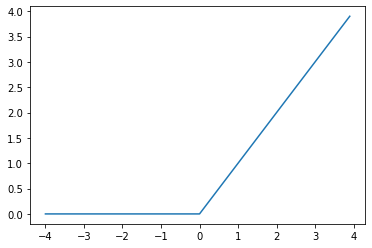

In [50]:
x = torch.arange(-4,4,0.1)
plt.plot(x, F.relu(x))

Тогда сеть из двух слоев будет выглядеть так:

In [51]:
def simple_net(x):
    res = x@w1+b1
    res = res.max(tensor(0.0))
    res = res@w2+b2
    return res

In [52]:
#задаем веса для двух слоев, размер второго слоя может быть любым, я поставила 30
w1 = init_params((28*28,30), torch.sqrt(torch.tensor(1./30)))
b1 = init_params(30, torch.sqrt(torch.tensor(1./30)))
w2 = init_params((30,10),torch.sqrt(torch.tensor(1./10)))
b2 = init_params(10, torch.sqrt(torch.tensor(1./10)))

params = w1,b1,w2,b2

In [53]:
epochs = 80
lr = 0.001
for i in range(epochs):
    train_epoch(simple_net, dl, lr, params)
    print(validate_epoch(simple_net, valid_dl), end=' ')

0.1421 0.2243 0.2989 0.368 0.4282 0.4835 0.5274 0.5631 0.5937 0.6178 0.6372 0.6525 0.6689 0.6825 0.6933 0.7061 0.7146 0.7252 0.7332 0.7419 0.7484 0.7546 0.76 0.765 0.7713 0.7761 0.7803 0.7854 0.7892 0.7939 0.797 0.8011 0.8038 0.8067 0.8101 0.8122 0.8142 0.8167 0.8187 0.8213 0.8236 0.8251 0.8272 0.8287 0.831 0.8333 0.8347 0.8365 0.8384 0.8399 0.8412 0.8433 0.8444 0.8458 0.847 0.8481 0.8485 0.8494 0.8504 0.8514 0.8529 0.854 0.8555 0.8564 0.8573 0.8587 0.8596 0.86 0.8607 0.8613 0.8619 0.8625 0.8637 0.8645 0.8656 0.8664 0.867 0.8682 0.8691 0.8698 

Или тоже самое, но с библиотечными функциями:

In [54]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,10)
)

In [55]:
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=cross_entropy_loss, metrics=batch_accuracy)

In [56]:
learn.fit(80, 0.001)

epoch,train_loss,valid_loss,batch_accuracy,time
0,2.323066,2.242063,0.107600,00:01
1,2.238540,2.170549,0.150900,00:01
2,2.149217,2.081092,0.184200,00:01
3,2.051738,1.976882,0.249500,00:01
4,1.936565,1.857309,0.400200,00:02
5,1.803392,1.730667,0.542100,00:01
6,1.657574,1.606008,0.577500,00:01
7,1.514135,1.488725,0.585600,00:01
8,1.384189,1.381572,0.594500,00:01
9,1.271495,1.285586,0.612000,00:01


Ну вот и все на сегодня. Статья получилась очень объемной и насыщенной, но, надеюсь, она вам понравилась. Как обычно, все вопросы и замечания жду в комментариях. До новых встреч)